In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import random
import copy
from functools import partial

import numpy as np
from scipy.optimize import fmin_l_bfgs_b
from scipy.stats import uniform

In [3]:
import pylab
%matplotlib inline

In [4]:
random.seed(0)
np.random.seed(0)

### Catapult environment

In [5]:
#import sys
#sys.path.append("../..")
from bolero.environment.catapult import Catapult
catapult = Catapult([(0, 0), (2.0, -0.5), (3.0, 0.5), (4, 0.25), 
                     (5, 2.5), (7, 0), (10, 0.5), (15, 0)])
catapult.init()

## Hit Landscape

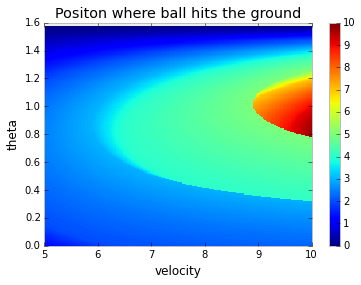

In [6]:
v = np.linspace(5.0, 10.0, 200)
theta = np.linspace(0.0, np.pi/2, 200)
V, Theta = np.meshgrid(v, theta)

Z = np.array([[catapult._shoot(V[i, j], Theta[i, j]) 
               for j in range(v.shape[0])]
              for i in range(theta.shape[0])])

pylab.pcolor(V, Theta, Z)
pylab.xlabel("velocity")
pylab.ylabel("theta")
pylab.colorbar()
pylab.clim(0, 10)
pylab.title("Positon where ball hits the ground")

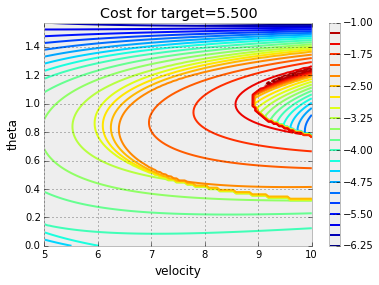

In [7]:
def catapult_reward(params, target):
    catapult.request_context((target - 2.0) / 8.0)
    catapult.set_inputs(params)
    catapult.step_action()
    return catapult.get_feedback()[0]

v = np.linspace(5.0, 10.0, 100)
theta = np.linspace(0.0, np.pi/2, 100)
V, Theta = np.meshgrid(v, theta)

Z = np.array([[partial(catapult_reward, target=5.5)([V[i, j], Theta[i, j]]) 
               for j in range(v.shape[0])]
               for i in range(theta.shape[0])])

pylab.contour(V, Theta, Z, 25)
pylab.xlabel("velocity")
pylab.ylabel("theta")
pylab.colorbar()
pylab.title("Cost for target=%.3f" % 5.5)

## Optimal Policy

In [8]:
num_targets = 100
contexts = np.linspace(2, 10, num_targets)

best_rewards = -1000 * np.ones(num_targets)
v_opt = np.empty(num_targets)
theta_opt = np.empty(num_targets)
reward = np.empty(1)
for k, target in enumerate(contexts):
    for _ in range(25):
        x0 = [uniform.rvs(5.0, 5.0), uniform.rvs(0.0, np.pi/2)]
        result = fmin_l_bfgs_b(lambda x, target=target: -catapult_reward(x, target=target),
                               x0, approx_grad=True,
                               bounds=[(5.0, 10.0), (0.0, np.pi/2)])
        if -result[1] > best_rewards[k]:
            best_rewards[k] = -result[1]
            v_opt[k] = result[0][0]
            theta_opt[k] = result[0][1]

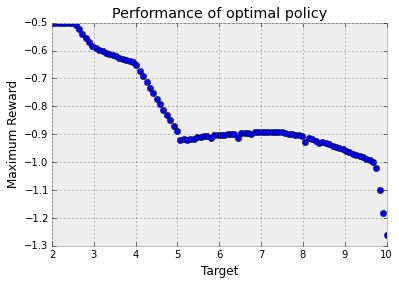

In [9]:
pylab.plot(contexts, best_rewards, 'bo', label="best reward")
pylab.xlabel("Target")
pylab.ylabel("Maximum Reward")
pylab.title("Performance of optimal policy")

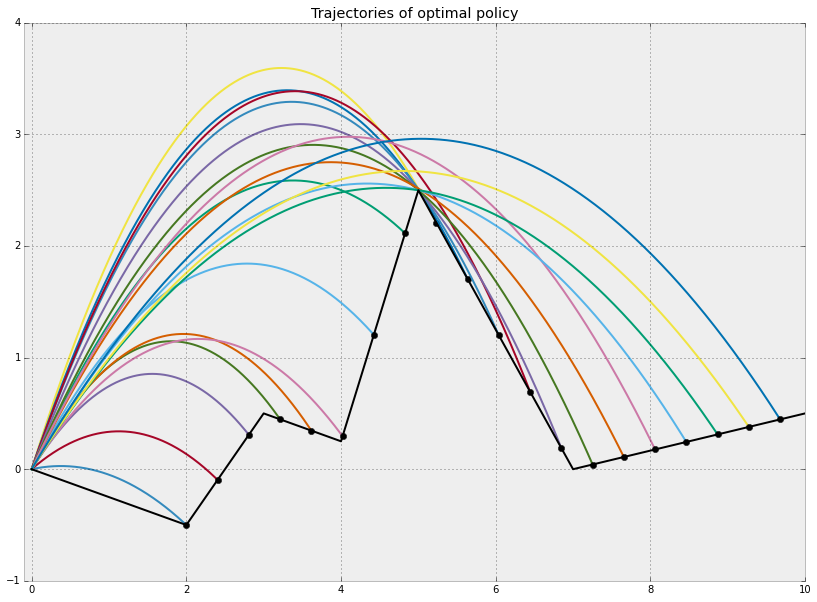

In [10]:
pylab.figure(figsize=(14, 10))

x = np.linspace(0, 10, 1000)
ys = np.interp(x, catapult.segments[:, 0], catapult.segments[:, 1])

for k in range(0, 100, 5):
    a, b, c = catapult._trajectory_params(v=v_opt[k], theta=theta_opt[k])
    y = a*x**2 + b*x + c
    select = np.where(np.logical_and.accumulate(y >= ys))
    pylab.plot(x[select], y[select])
    x0 = catapult._intersect(a, b, c)
    pylab.plot([x0], [a*x0**2 + b*x0 + c], 'ko')

pylab.plot(catapult.segments[:, 0], catapult.segments[:, 1], 'k')
pylab.xlim(-0.1, 10)
pylab.ylim(-1, 4)
pylab.title("Trajectories of optimal policy")

## Contextual Bayesian Optimization

In [11]:
import sys
sys.path.append("../..")

from bolero_bayes_opt import BOCPSOptimizer
from bolero_bayes_opt import KernelRegressionPolicy

from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

In [12]:
n_rollouts = 100
evaluation_frequency = 5  # how often to evaluate learned policy
verbose = False

samples = np.empty((n_rollouts, 3))
rewards = np.empty((n_rollouts))
offline_eval = np.empty((n_rollouts / evaluation_frequency, contexts.shape[0]))

In [13]:
kernel = C(100.0, (1.0, 10000.0)) \
    * RBF(l=(1.0, 1.0, 1.0), l_bounds=[(0.1, 100), (0.1, 100), (0.1, 100)])

opt = BOCPSOptimizer(
    boundaries=[(5, 10), (0, np.pi/2)],
    acquisition_function="UCB", acq_fct_kwargs=dict(kappa=1.0),
    optimizer="direct+lbfgs", optimizer_kwargs=dict(maxf=100),
    gp_kwargs=dict(kernel=kernel, normalize_y=True, sigma_squared_n=1e-5))     

In [14]:
opt.init(2, 1)    
params_ = np.zeros(2)
reward = np.empty(1)
for rollout in range(n_rollouts):
    context = uniform.rvs(2, 8, size=1)
    opt.set_context(context)

    opt.get_next_parameters(params_)
    samples[rollout] = (context[0], params_[0], params_[1])

    reward = catapult_reward(params_, context)

    rewards[rollout] = reward
    opt.set_evaluation_feedback(reward)
    
    if verbose:
        print "Rollout %d: Context: %.3f Velocity %.3f Angle %.3f Reward %.3f" \
            % (rollout, context[0], params_[0], params_[1], reward)


    if (rollout + 1) % evaluation_frequency == 0:
        pol = opt.best_policy()
        offline_eval[rollout / evaluation_frequency] = \
            [catapult_reward(pol(c, explore=False), c) for c in contexts] - best_rewards
        if verbose:
            print "Rollout %d: Average regret of policy %.3f" \
            % (rollout, offline_eval[rollout / evaluation_frequency].mean())

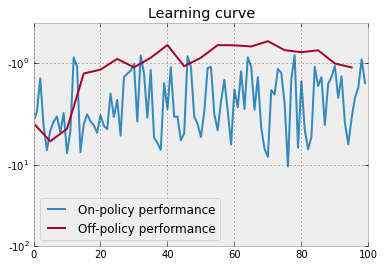

In [15]:
pylab.plot(range(n_rollouts), rewards, label="On-policy performance")
pylab.plot(range(0, n_rollouts, evaluation_frequency), offline_eval.mean(1), label="Off-policy performance")
pylab.yscale("symlog")
pylab.legend(loc="best")
pylab.title("Learning curve")

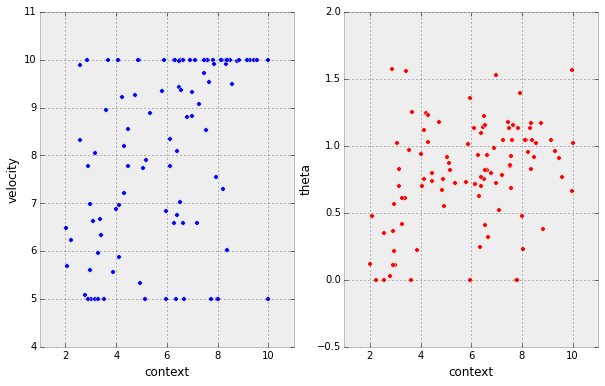

In [16]:
pylab.figure(figsize=(10, 6))
pylab.subplot(1, 2, 1)
pylab.scatter(samples[:, 0], samples[:, 1], c='b')
pylab.xlabel("context")
pylab.ylabel("velocity")
pylab.subplot(1, 2, 2)
pylab.scatter(samples[:, 0], samples[:, 2], c='r')
pylab.xlabel("context")
pylab.ylabel("theta")

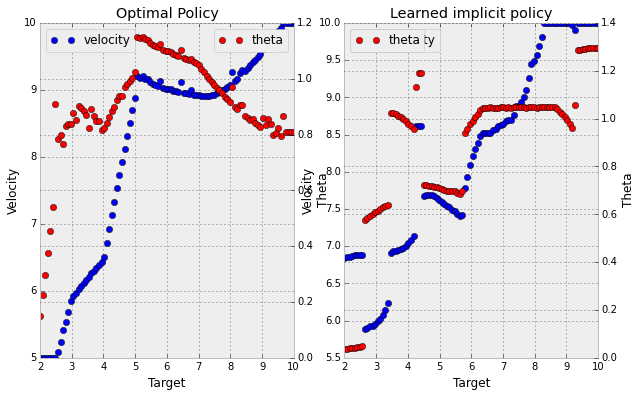

In [17]:
pol = opt.best_policy()
actions_select = np.array([pol(c, explore=False) for c in contexts])

pylab.figure(figsize=(10, 6))
pylab.subplot(1, 2, 1)
ax_v = pylab.gca()
ax_theta = pylab.twinx()
ax_v.plot(contexts, v_opt, 'bo', label="velocity")
ax_theta.plot(contexts, theta_opt, 'ro', label="theta")
ax_v.set_xlabel("Target")
ax_v.set_ylabel("Velocity")
ax_theta.set_ylabel("Theta")
ax_v.legend(loc='best')
ax_theta.legend(loc=0)
ax_v.set_title("Optimal Policy")

pylab.subplot(1, 2, 2)
ax_v = pylab.gca()
ax_theta = pylab.twinx()
ax_v.plot(contexts, actions_select[:, 0] , 'bo', label="velocity")
ax_theta.plot(contexts, actions_select[:, 1], 'ro', label="theta")
ax_v.set_xlabel("Target")
ax_v.set_ylabel("Velocity")
ax_theta.set_ylabel("Theta")
ax_v.legend(loc='best')
ax_theta.legend(loc=0)
ax_v.set_title("Learned implicit policy")

In [ ]:
from bolero.representation.ul_policies import BoundedScalingPolicy
from bolero_bayes_opt import KernelRegressionPolicy

policy = KernelRegressionPolicy(2, 1)
policy = BoundedScalingPolicy(policy, scaling="auto", 
                              bounds=np.array(opt.boundaries))
opt.policy = policy
opt.policy_fitted = False
pol = opt.best_policy(training=["model-free", "model-based"], variance=10.0, maxfun=10000)
actions_select = np.array([pol(c, explore=False) for c in contexts])

ax_v = pylab.gca()
ax_theta = pylab.twinx()
ax_v.plot(contexts, actions_select[:, 0, 0] , 'bo', label="velocity")
ax_theta.plot(contexts, actions_select[:, 0, 1], 'ro', label="theta")
ax_v.set_xlabel("Target")
ax_v.set_ylabel("Velocity")
ax_theta.set_ylabel("Theta")
ax_v.legend(loc='best')
ax_theta.legend(loc=0)
ax_v.set_title("Learned explicit policy")